# Walmart Demand Forecasting Notebook
# Robert Andrews
# rea3ah@virginia.edu

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [9]:
!pip install lazypredict
!pip install statsmodels
!pip install ann_visualizer
!pip install visualkeras
!pip install PIL
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# import data packages
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras 
import lazypredict as lazy
from statsmodels.tsa.seasonal import seasonal_decompose as sdc

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Walmart Data**

In [12]:
# try reading in walmart clean
walmart = pd.read_csv('walmart_clean.csv', index_col='date', parse_dates=True)

In [13]:
# view first rows
walmart.head(5)

,cpi,fuel_price,unemployment,temperature,holiday,weekly_sales
date,,,,,,
2010-02-05,-0.097130,-1.402699,0.330835,-1.453396,False,49750740.50
2010-02-12,-0.097494,-1.450172,0.325778,-1.448850,True,48336677.63
2010-02-19,-0.098648,-1.499104,0.330631,-1.249559,False,48276993.78
2010-02-26,-0.089658,-1.472985,0.322593,-1.163302,False,43968571.13
2010-03-05,-0.088730,-1.372282,0.328665,-0.960329,False,46871470.30


In [14]:
# drop other features but weekly sales 
walmart = walmart[['weekly_sales']]

# **EDA Time Series Data**

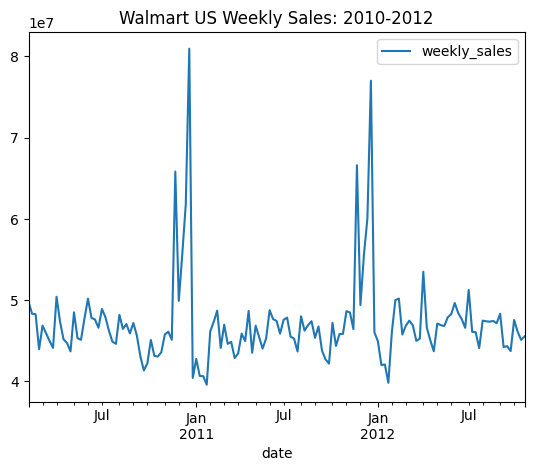

In [36]:
walmart.plot()
plt.title("Walmart US Weekly Sales: 2010-2012");

<Figure size 1800x900 with 0 Axes>

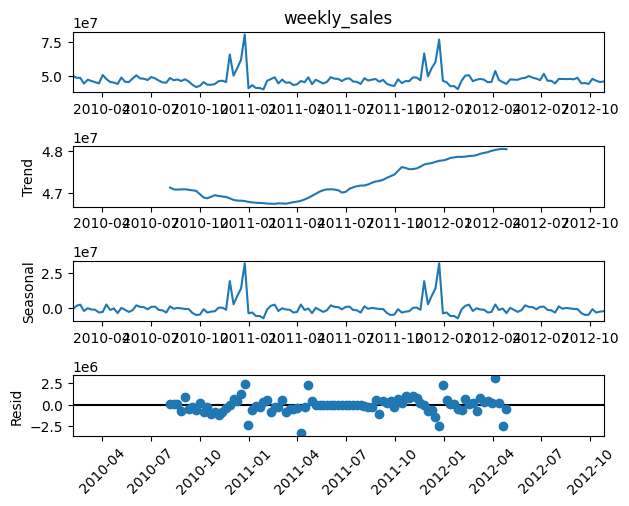

In [16]:
# decompose sales data
results = sdc(walmart['weekly_sales'])
plt.figure(figsize=(18,9))
results.plot();
plt.xticks(rotation = 45);


# **Split Data**

In [17]:
len(walmart)

143

In [18]:
train = walmart.iloc[:131] # use all but last 12 weeks 
valid = walmart.iloc[110:131]
test = walmart.iloc[131:]

In [19]:
# use minmax scaler to convert sales 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [20]:
walmart.head(), walmart.tail(12)

(            weekly_sales
 date                    
 2010-02-05   49750740.50
 2010-02-12   48336677.63
 2010-02-19   48276993.78
 2010-02-26   43968571.13
 2010-03-05   46871470.30,
             weekly_sales
 date                    
 2012-08-10   47403451.04
 2012-08-17   47354452.05
 2012-08-24   47447323.60
 2012-08-31   47159639.43
 2012-09-07   48330059.31
 2012-09-14   44226038.65
 2012-09-21   44354547.11
 2012-09-28   43734899.40
 2012-10-05   47566639.31
 2012-10-12   46128514.25
 2012-10-19   45122410.57
 2012-10-26   45544116.29)

# **Scale Data for Training**

In [21]:
# transfor data with scaler
scaler.fit(train)
train = scaler.transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [22]:
# check make sure it worked
train[:5]

array([[0.24559651],
       [0.21138385],
       [0.20993982],
       [0.10569932],
       [0.17593376]])

In [23]:
# check shape
train.shape, valid.shape, test.shape

((131, 1), (21, 1), (12, 1))

In [24]:
# create time series generator
from keras.preprocessing.sequence import TimeseriesGenerator

In [25]:
# define generator
n_input = 12 # because we want to predict the last twelve weeks
n_features = 1 # weekly_sales is the only feature
generator = TimeseriesGenerator(train, train, length = n_input, batch_size=1)
valid_gen = TimeseriesGenerator(valid, valid, length = n_input, batch_size=1)

In [26]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.24559651 0.21138385 0.20993982 0.10569932 0.17593376 0.1530439
 0.13038756 0.10970086 0.26188166 0.18788154 0.13509806 0.12422951]
Predict this y: 
 [[0.09932539]]


In [27]:
X,y = valid_gen[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.17666044 0.13050417 0.1372561  0.33636432 0.17007362 0.13240914
 0.0996078  0.1820484  0.17725016 0.17478377 0.20063626 0.21005247]
Predict this y: 
 [[0.24318749]]


In [28]:
X.shape

(1, 12, 1)

In [29]:
# We do the same thing for 12 weeks
n_input = 12
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

# **Design and Train LSTM Network**

In [30]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [31]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
model = keras.models.Sequential([
    keras.layers.LSTM(int(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(int(20), return_sequences=True),
    keras.layers.Dense(int(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [32]:
# from ann_visualizer.visualize import ann_viz
# from graphviz import Source
# ann_viz(model,view=True)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 dense (Dense)               (None, None, 1)           21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


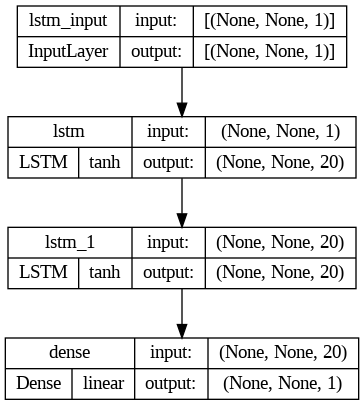

In [34]:
'''
c/o Angel Das
Towards Data Science
https://towardsdatascience.com/how-to-visualize-neural-network-architectures-in-python-567cd2aa6d62

'''
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [35]:
history = model.fit(generator, epochs=50,
                    validation_data=valid_gen,
                    callbacks=[earlystopping])

Epoch 1/50
119/119 [==============================] - 16s 43ms/step - loss: 0.0259 - mean_absolute_percentage_error: 1298262.3750 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 28.5497
Epoch 2/50
119/119 [==============================] - 3s 21ms/step - loss: 0.0220 - mean_absolute_percentage_error: 1403149.8750 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 23.8456
Epoch 3/50
119/119 [==============================] - 3s 26ms/step - loss: 0.0213 - mean_absolute_percentage_error: 1504411.1250 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 23.4499
Epoch 4/50
119/119 [==============================] - 4s 33ms/step - loss: 0.0214 - mean_absolute_percentage_error: 1490602.6250 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 22.4281
Epoch 5/50
119/119 [==============================] - 3s 26ms/step - loss: 0.0210 - mean_absolute_percentage_error: 1585000.7500 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 24.8279
Epoch 6/50
119/119 [=========

In [37]:
'''
c/o Rich Nguyen, PHD
nguyen@virginia.edu
'''
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

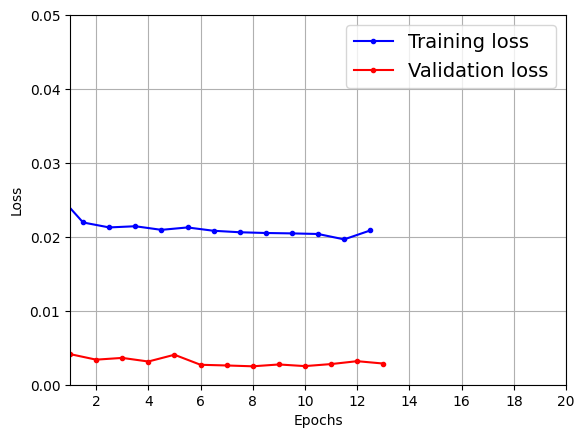

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show();

In [42]:
test

array([[0.18880482],
       [0.18761931],
       [0.18986629],
       [0.18290589],
       [0.21122372],
       [0.11192864],
       [0.11503785],
       [0.10004573],
       [0.19275309],
       [0.15795825],
       [0.13361599],
       [0.14381898]])

# **Generate Predictions**

In [70]:
df_preds = walmart.loc['2012-08-10':]

In [71]:
# reshape preds into array
preds1 = preds.reshape(12,1)
# rescale weekly sales
true_preds = scaler.inverse_transform(preds1)

In [72]:
true_preds.shape

(12, 1)

In [73]:
true_preds

array([[45439380.],
       [45439728.],
       [45439064.],
       [45441128.],
       [45432740.],
       [45462332.],
       [45461396.],
       [45465904.],
       [45438208.],
       [45448556.],
       [45455828.],
       [45452776.]], dtype=float32)

In [74]:
df_preds['Predictions'] = [45439380,
       45439728.,
       45439064.,
       45441128.,
       45432740.,
       45462332.,
       45461396.,
       45465904.,
       45438208.,
       45448556.,
       45455828.,
       45452776.]

<ipython-input-74-5427d4d1ecfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['Predictions'] = [45439380,


In [75]:
df_preds

,weekly_sales,Predictions
date,,
2012-08-10,47403451.04,45439380.0
2012-08-17,47354452.05,45439728.0
2012-08-24,47447323.60,45439064.0
2012-08-31,47159639.43,45441128.0
2012-09-07,48330059.31,45432740.0
2012-09-14,44226038.65,45462332.0
2012-09-21,44354547.11,45461396.0
2012-09-28,43734899.40,45465904.0
2012-10-05,47566639.31,45438208.0


In [76]:
df_preds['Error'] = abs(((df_preds.weekly_sales - df_preds.Predictions)/df_preds.weekly_sales))

<ipython-input-76-3413a2bdfa1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['Error'] = abs(((df_preds.weekly_sales - df_preds.Predictions)/df_preds.weekly_sales))


In [77]:
df_preds.Error = 1-df_preds.Error

<ipython-input-77-8629080d917d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds.Error = 1-df_preds.Error


In [78]:
df_preds['Accuracy'] = df_preds.Error

<ipython-input-78-97429acc76cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['Accuracy'] = df_preds.Error


In [79]:
df_preds = df_preds[['weekly_sales','Predictions','Accuracy']]

In [80]:
df_preds.Accuracy = round(df_preds.Accuracy, 3)
df_preds.Accuracy

<ipython-input-80-b4543669c55e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds.Accuracy = round(df_preds.Accuracy, 3)


date
2012-08-10    0.959
2012-08-17    0.960
2012-08-24    0.958
2012-08-31    0.964
2012-09-07    0.940
2012-09-14    0.972
2012-09-21    0.975
2012-09-28    0.960
2012-10-05    0.955
2012-10-12    0.985
2012-10-19    0.993
2012-10-26    0.998
Name: Accuracy, dtype: float64

In [81]:
df_preds

,weekly_sales,Predictions,Accuracy
date,,,
2012-08-10,47403451.04,45439380.0,0.959
2012-08-17,47354452.05,45439728.0,0.960
2012-08-24,47447323.60,45439064.0,0.958
2012-08-31,47159639.43,45441128.0,0.964
2012-09-07,48330059.31,45432740.0,0.940
2012-09-14,44226038.65,45462332.0,0.972
2012-09-21,44354547.11,45461396.0,0.975
2012-09-28,43734899.40,45465904.0,0.960
2012-10-05,47566639.31,45438208.0,0.955
